In [1]:
from IPython.display import HTML
#Instruction for hiding the code section for presentation
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# New York City Parking Ticket Analysis
<ul>
    <li><a href = '#introduction'>Introduction</a></li>
    <li><a href = '#Preparation: Raw_data loading'>Preparation: Raw_data loading</a></li>
    <li><a href = '#Overview - Distribution of parking tickets issued over the fiscal year.'>Data Overview - Distribution of parking tickets issued over the fiscal year.</a></li>
    <li><a href = '#Distribution of the Traffic Tickets Issued on Different Day of the Week and Each Month'>Distribution of the Traffic Tickets Issued on Different Day of the Week and Each Month</a></li>
    <li><a href = '#Total Ticket Issued on Different Hours of the Day'>Total Ticket Issued on Different Hours of the Day</a></li>
    <li><a href = '#Tickets Issued for Different Plate Types'>Tickets Issued for Different Plate Types</a></li>
    <li><a href = '#violation code with Plate Types'>violation code with Plate Types</a></li>
    <li><a href = '#Plate Type = PAS, Violation Code = 21'>Plate Type = PAS, Violation Code = 21</a></li>
    <li><a href = '#Total Tickets Issued by Each Precinct of NYC '>Total Tickets Issued by Each Precinct of NYC </a></li>
<ul>

In [396]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline 

##### Preparation: Raw_data loading

In [397]:
#Load Dataset from Fiscal Year 2015, 2016 and 2017
years = [2015, 2016, 2017]
raw_data_15_17 = []
for year in years:
    filename = "Parking_Violations_Issued_-_Fiscal_Year_" + str(year) + ".csv"
    print("loading data", filename, "...")
    raw_data = pd.read_csv(filename, low_memory = False)
    raw_data_15_17.append(raw_data)
    print('done')
    

loading data Parking_Violations_Issued_-_Fiscal_Year_2015.csv ...
done
loading data Parking_Violations_Issued_-_Fiscal_Year_2016.csv ...
done
loading data Parking_Violations_Issued_-_Fiscal_Year_2017.csv ...
done


In [398]:
#NYC fiscal year starts from July to June next year
start_dates = []
end_dates = []
for year in years:
    start_dates.append(str(year-1) + "-07-01")
    end_dates.append(str(year) + "-06-30")

#### 1. Overview - Distribution of parking tickets issued over the fiscal year.

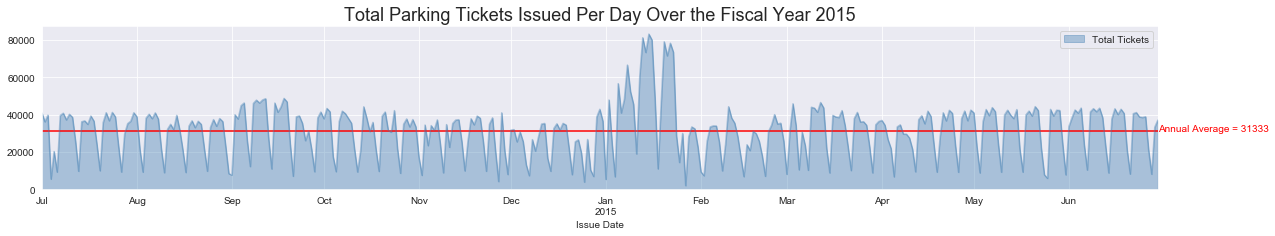

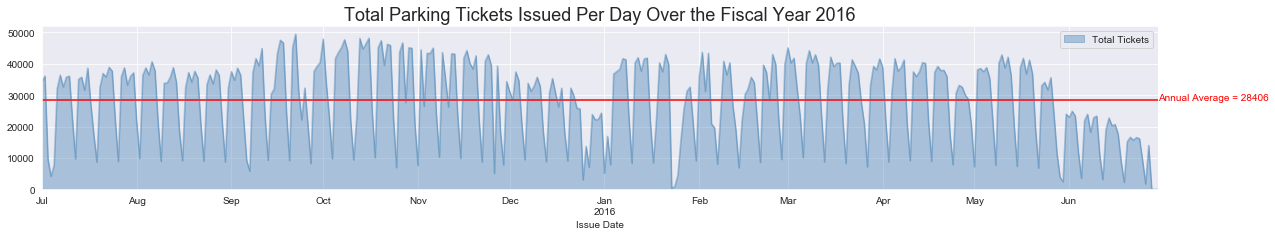

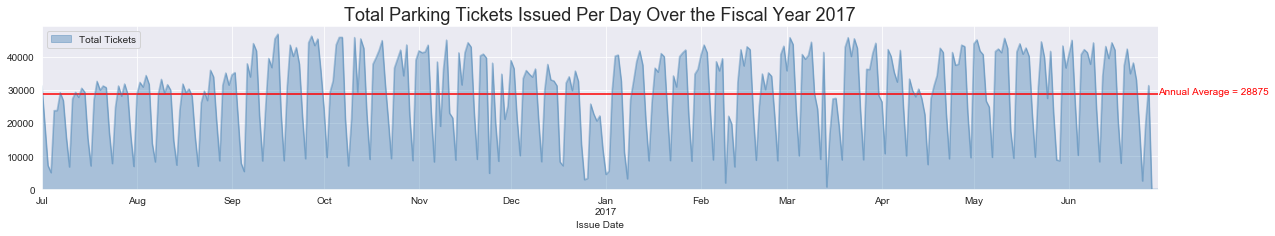

In [468]:
Date_Total_list = []
for raw_data, year, start_date, end_date in zip(raw_data_15_17, years, start_dates, end_dates):    
    #Data Cleaning Section
    Date_SNum = raw_data[['Issue Date','Summons Number']]
    Date_SNum = Date_SNum.groupby('Issue Date', as_index = False).count() 
    Date_SNum['Issue Date'] = pd.to_datetime(Date_SNum['Issue Date'])
    Date_SNum = Date_SNum.set_index('Issue Date')
    Date_SNum = Date_SNum.loc[start_date : end_date]#Select the tickets issued inside the fiscal year range
    Date_SNum = Date_SNum.sort_index()
    Date_Total = Date_SNum.rename(columns = {"Summons Number" : "Total Tickets"})
    Date_Total_list.append(Date_Total)
    if year == 2015:
        Date_Total_all = Date_Total.rename(columns = {"Total Tickets" : "2015"})
        Date_Total_all = Date_Total_all.reset_index()
    else:
        Date_Total = Date_Total.reset_index()
        Date_Total_all[str(year)] = Date_Total['Total Tickets']
        Date_Total = Date_Total.set_index('Issue Date')
    
    #Graph Section
    fig = plt.figure(figsize = (20,3))
    ax = fig.add_subplot(1,1,1)
    Date_Total.plot(ax = ax, kind = 'area', color = 'steelblue', alpha = 0.4, grid = True)
    plt.title("Total Parking Tickets Issued Per Day Over the Fiscal Year " + str(year), fontsize = 18 )
    ax.hlines(y = Date_Total['Total Tickets'].mean(), xmin = start_date, xmax = end_date, color = 'r', )
    plt.text(end_date, Date_Total['Total Tickets'].mean(), ("Annual Average = " + str(int(Date_Total['Total Tickets'].mean()))), color = 'r')

In [469]:
Date_Total_all = Date_Total_all.set_index('Issue Date')
Date_Total_all['Average'] = Date_Total_all.mean(axis = 1)
Date_Total_all['STD'] = Date_Total_all[['2015','2016','2017']].std(axis = 1)
Date_Total_all['Average+'] = Date_Total_all['Average'] + Date_Total_all['STD']
Date_Total_all['Average-'] = Date_Total_all['Average'] - Date_Total_all['STD']

Text(0.5, 1.0, 'Average Total Parking Tickets Issued Per Day Over Three Fiscal Year (2015,2016,2017)  \nRed shade stands for standard error')

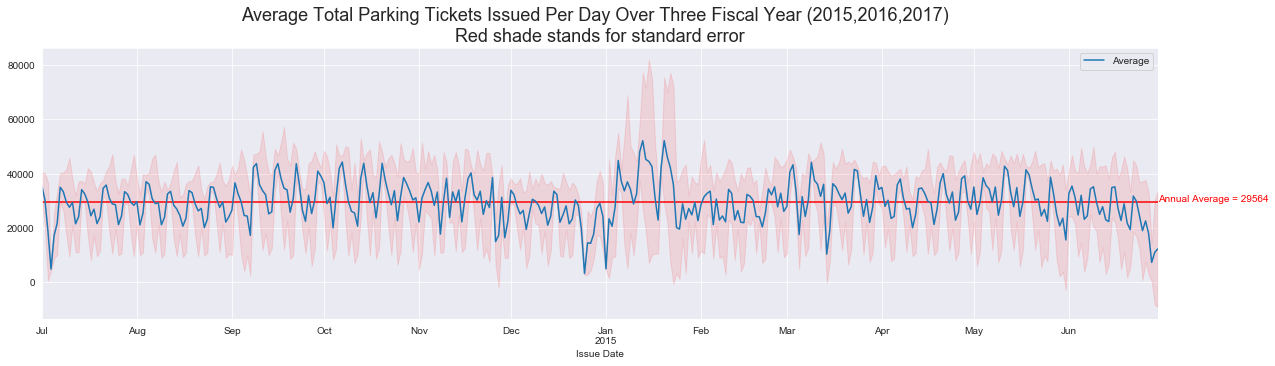

In [471]:
fig2 = plt.figure(figsize = (20,8))
ax2 = fig2.add_subplot(1,1,1)
ax2 = Date_Total_all[['Average']].plot(ax = ax2, kind = 'line', figsize = (20,5), alpha = 1, grid = True)
plt.fill_between(Date_Total_all.index, Date_Total_all['Average+'], Date_Total_all['Average-'], alpha = 0.1, color = 'r', label = 'std' )
ax2.hlines(y = Date_Total_all['Average'].mean(), xmin = start_dates[0], xmax = end_dates[0], color = 'r')
plt.text(end_dates[0], Date_Total_all['Average'].mean(), ("Annual Average = " + str(int(Date_Total_all['Average'].mean()))), color = 'r')
plt.title("Average Total Parking Tickets Issued Per Day Over Three Fiscal Year (2015,2016,2017)  \nRed shade stands for standard error", fontsize = 18 )


#### 2. Distribution of the Traffic Tickets Issued on Different Day of the Week and Each Month

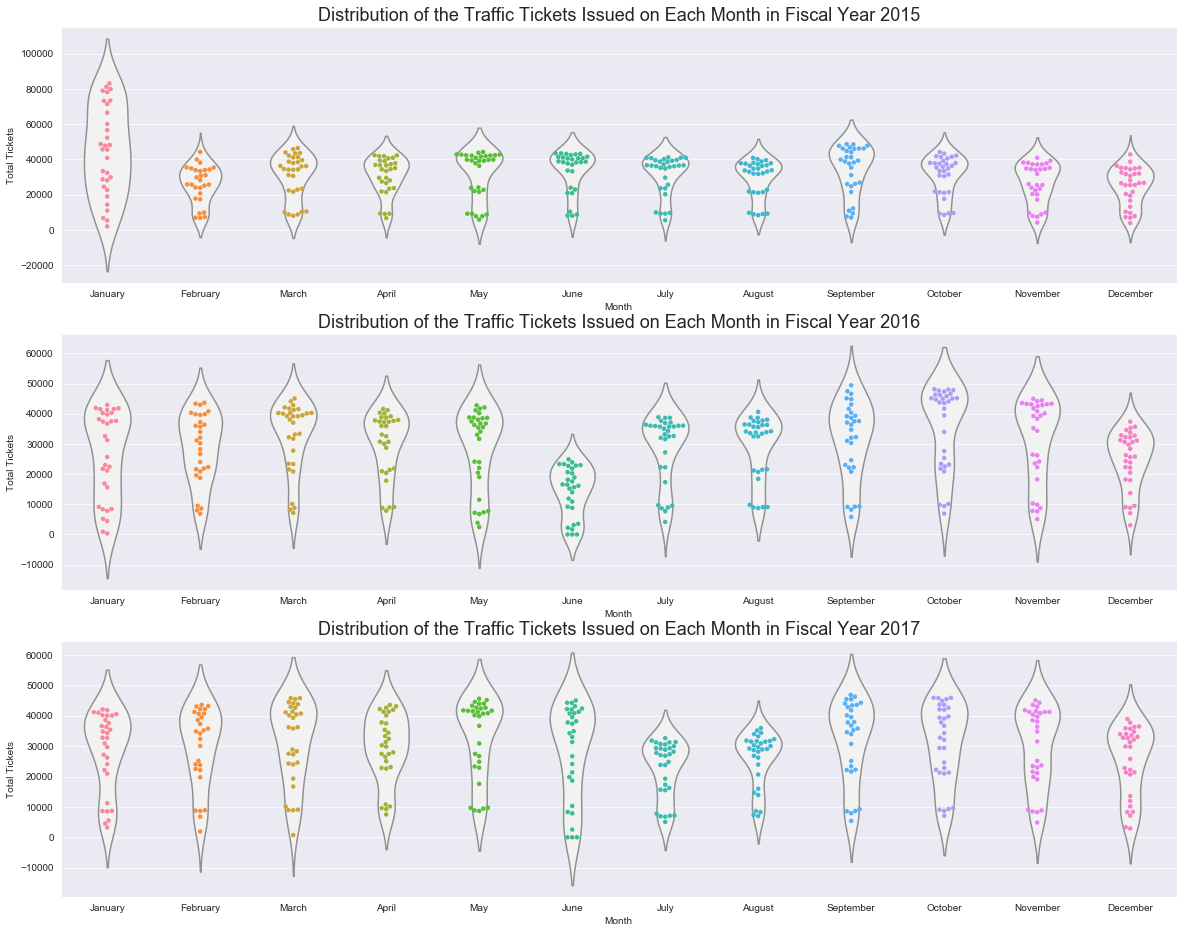

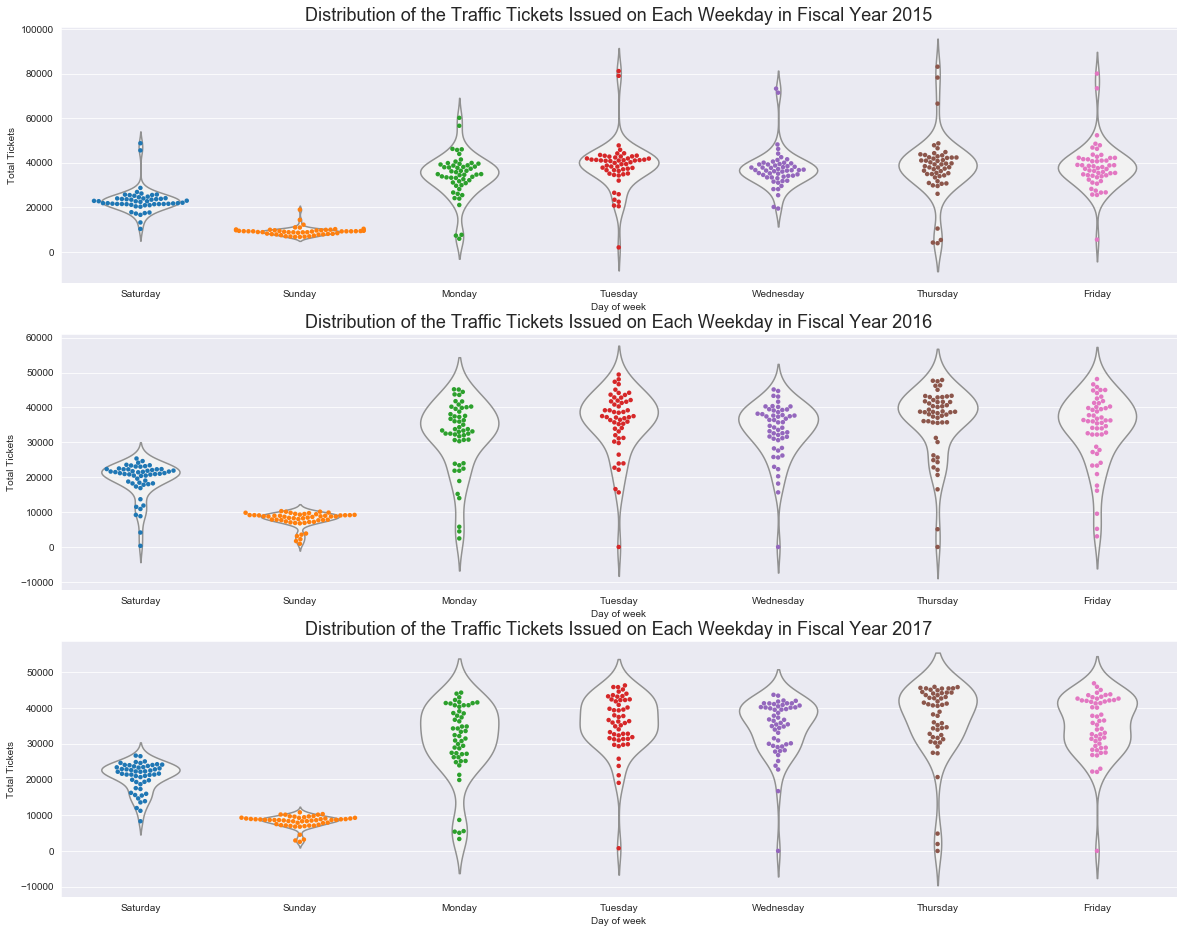

In [402]:
fig3, axes3 = plt.subplots(3,1, figsize = (20,16))
for Date_Total, year, i in zip(Date_Total_list, years, range(3)):    
    Date_Total["Month"] = Date_Total.index.month_name()
    sns.set_style("darkgrid")
    #violin plot for the number of tickets gave out on each Month
    sns.violinplot(ax = axes3[i], x = "Month", y = "Total Tickets", data = Date_Total,  height = 2.5, width = 0.5, order = ["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], scale = "count", inner = None, color = "0.95")
    sns.swarmplot(ax = axes3[i], x = "Month", y = "Total Tickets", data = Date_Total, order = ["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], size = 4.5)
    axes3[i].set_title('Distribution of the Traffic Tickets Issued on Each Month in Fiscal Year ' + str(year), fontsize = 18)

fig4, axes4 = plt.subplots(3,1, figsize = (20,16))
for Date_Total, year, i in zip(Date_Total_list, years, range(3)):  
    Date_Total["Day of week"] = Date_Total.index.day_name()
    #violin plot for the number of tickets gave out on each weekday
    sns.violinplot(ax = axes4[i], x = "Day of week", y = "Total Tickets", data = Date_Total, height = 2.5, width = 0.5, order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], scale = 'count', inner = None, color = "0.95")
    sns.swarmplot(ax = axes4[i], x = "Day of week", y = "Total Tickets", data = Date_Total, order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], size = 4.5)
    axes4[i].set_title('Distribution of the Traffic Tickets Issued on Each Weekday in Fiscal Year ' + str(year), fontsize = 18)


#### 3. Total Ticket Issued on Different Hours of the Day

In [403]:
#Function to clean the Violatime input, it will convert '1000P' original entry to a integer 2200. If invalid character
#presents, return -1
def cleanViolationTime(input):
    try:
        h, m, A_P = int(input[0:2]), int(input[2:4]), input[4]
        if A_P not in ['A','P']:
            return -1
        else:
            if A_P == 'P':
                if h == 12:
                    h = 0
                h = (h + 12)*60
            if A_P == 'A' and h == 12:
                h = 0
            if A_P == 'A': 
                h = h*60
            return (h + m)
    except:
        return -1

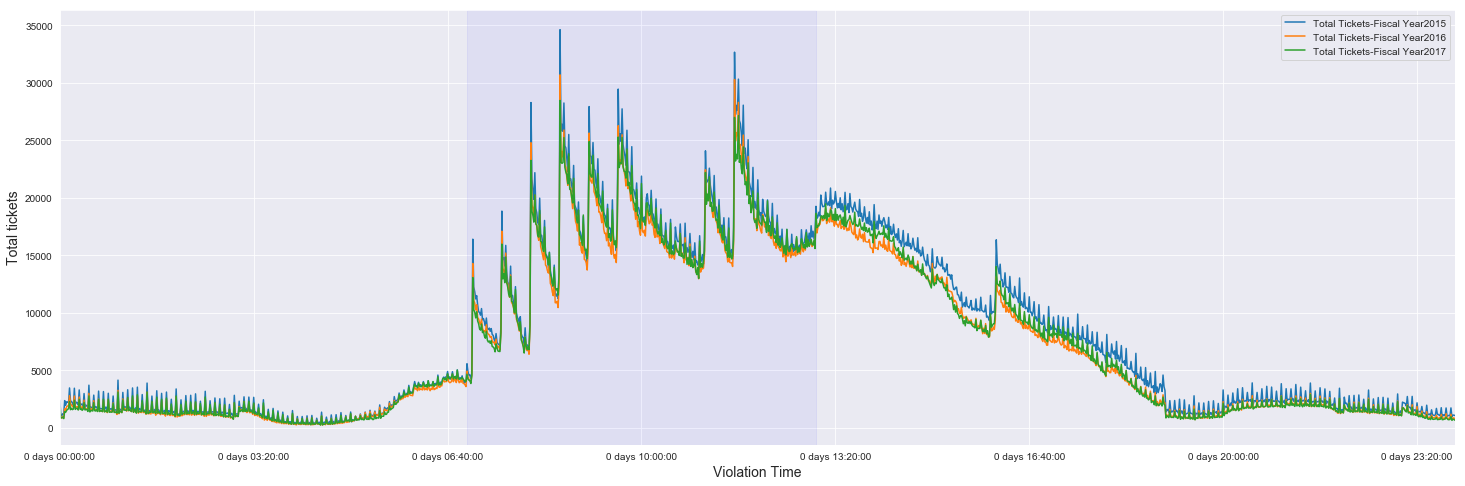

In [547]:
fig5 = plt.figure(figsize = (25,8))
ax = fig5.add_subplot(1,1,1)
for raw_data, year in zip(raw_data_15_17, years):
    #Cleanning the dataset
    hour_data = raw_data[['Violation Time', 'Summons Number']]
    hour_data = hour_data.groupby('Violation Time', as_index = False).count()
    hour_data = hour_data.loc[hour_data['Summons Number'] > 10] #I found this is a very effective way to filter all invalid data entries since they are all infrequent events.
    hour_data = hour_data.rename(columns = {'Summons Number' : ('Total Tickets-Fiscal Year' + str(year))})
    hour_data['Cleaned Violation Time'] = hour_data['Violation Time'].apply(cleanViolationTime)
    hour_data['Cleaned Violation Time'] = hour_data['Cleaned Violation Time'].astype('timedelta64[m]')
    hour_data = hour_data.groupby('Cleaned Violation Time').sum()
    hour_data.index = hour_data.index.map(str)
    hour_data.plot(ax = ax, kind = 'line', grid = True, alpha = 1)
    ax.set_xlabel("Violation Time", fontsize = 14)
    ax.set_ylabel("Total tickets", fontsize = 14)
ax = ax.axvspan(420,780, alpha = 0.05, color = 'b' )
    

#### 4. Tickets Issued for Different Plate Types

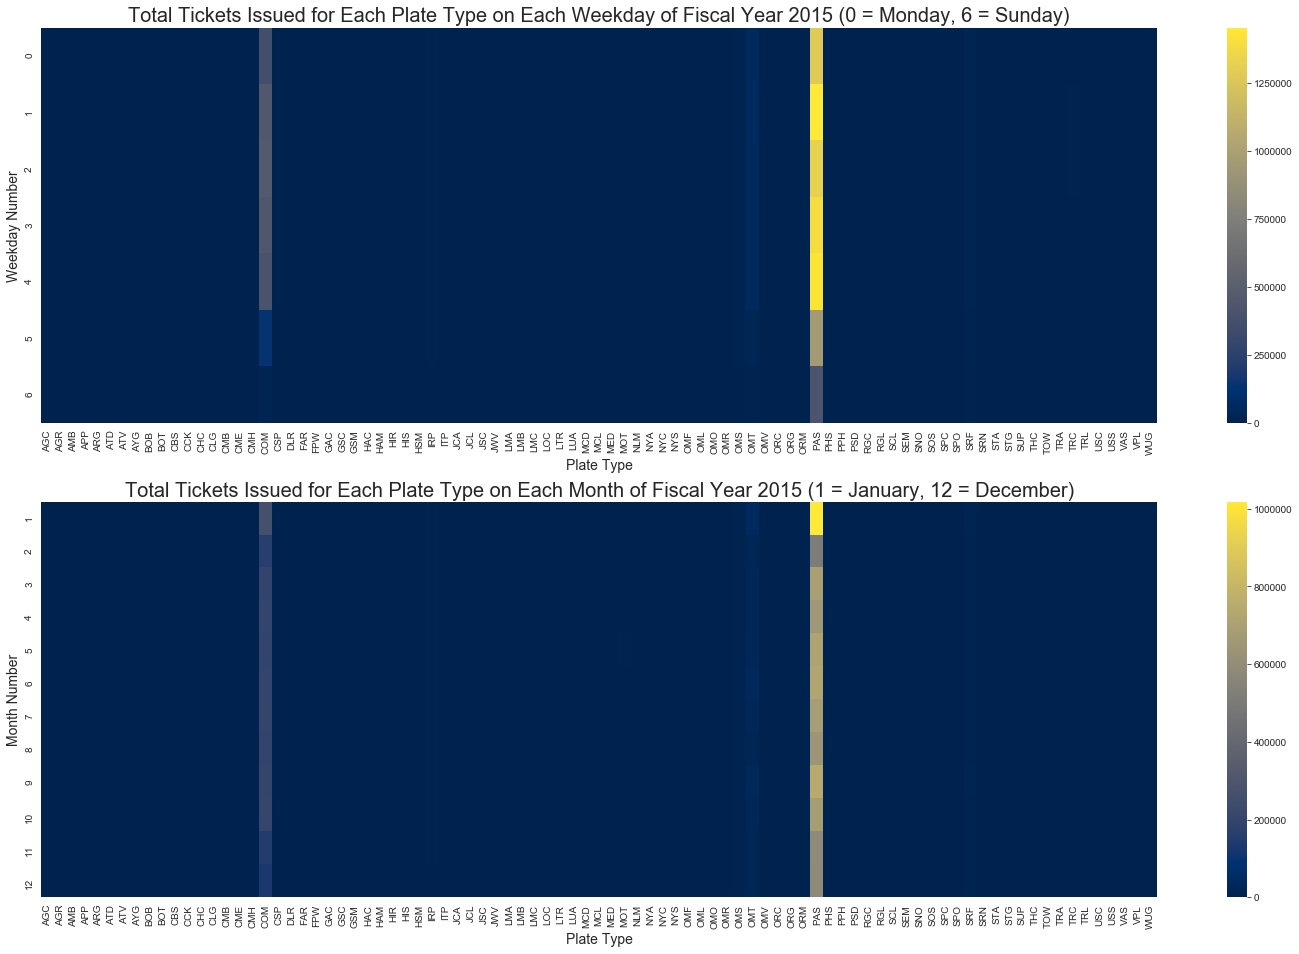

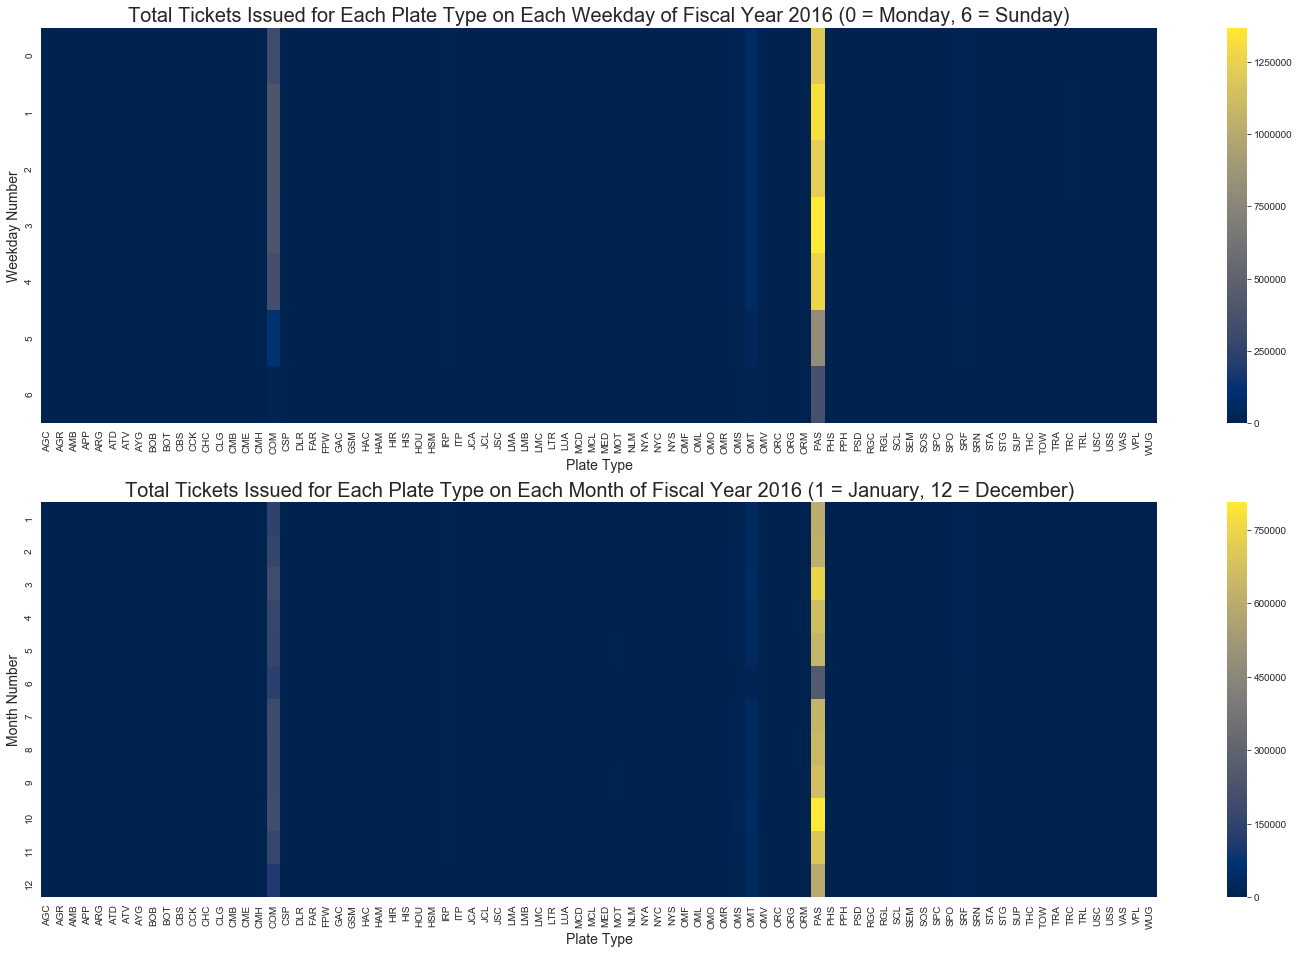

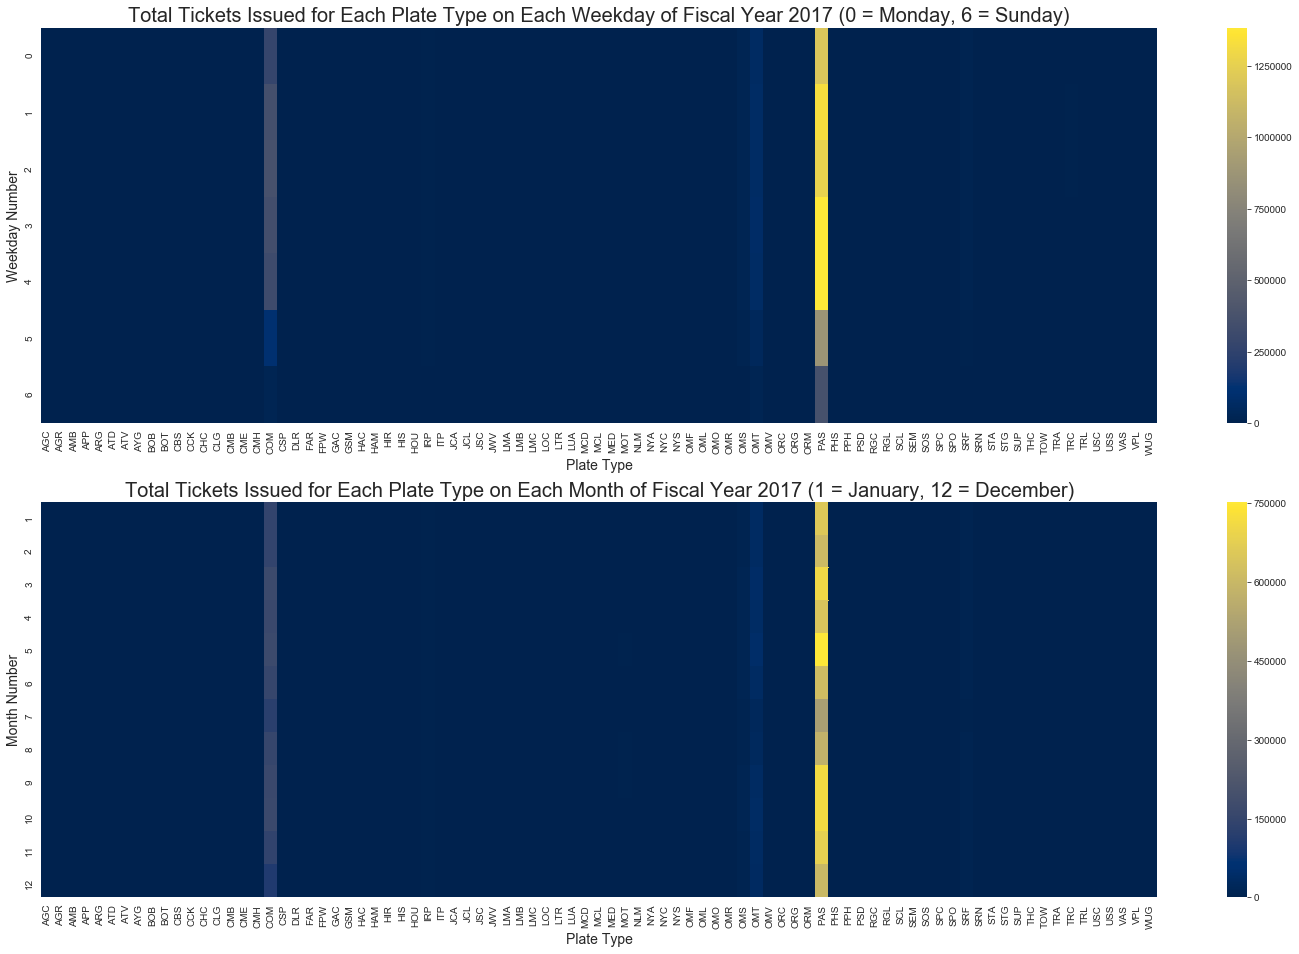

In [539]:
for raw_data, start_date, end_date, year in zip(raw_data_15_17, start_dates, end_dates, years):
    #Prepare the dataset
    Date_PT_TotalTX = raw_data[['Issue Date','Plate Type','Summons Number']]
    Date_PT_TotalTX = Date_PT_TotalTX.fillna("not_valid")
    Date_PT_TotalTX = Date_PT_TotalTX.groupby(['Issue Date','Plate Type'], as_index = False).count()
    Date_PT_TotalTX['Issue Date'] = pd.to_datetime(Date_PT_TotalTX['Issue Date'])
    Date_PT_TotalTX = Date_PT_TotalTX.set_index('Issue Date')
    Date_PT_TotalTX = Date_PT_TotalTX.loc[start_date:end_date]
    Date_PT_TotalTX = Date_PT_TotalTX.loc[Date_PT_TotalTX['Plate Type'] != '999']
    Date_PT_TotalTX['Month Number'] = Date_PT_TotalTX.index.month
    Date_PT_TotalTX['Weekday Number'] = Date_PT_TotalTX.index.weekday
    Weekday_PT_TotalTX = Date_PT_TotalTX.groupby(['Weekday Number', 'Plate Type']).sum()
    Month_PT_TotalTX = Date_PT_TotalTX.groupby(['Month Number','Plate Type']).sum()

    #Tranform the table for heat plot
    Weekday_PT_TotalTX = Weekday_PT_TotalTX.reset_index()
    Month_PT_TotalTX = Month_PT_TotalTX.reset_index()
    Weekday_PT_TotalTX = Weekday_PT_TotalTX.pivot(index = 'Weekday Number', columns = 'Plate Type', values = 'Summons Number')
    Weekday_PT_TotalTX = Weekday_PT_TotalTX.fillna(0)
    Month_PT_TotalTX = Month_PT_TotalTX.pivot(index='Month Number', columns='Plate Type', values='Summons Number')
    Month_PT_TotalTX = Month_PT_TotalTX.fillna(0)

    #Making Heatmap
    fig6, axes = plt.subplots(2,1, figsize=(25,16)) 
    sns.heatmap(ax = axes[0], data = Weekday_PT_TotalTX, cmap = "cividis")
    axes[0].set_title("Total Tickets Issued for Each Plate Type on Each Weekday of Fiscal Year " + str(year) + " (0 = Monday, 6 = Sunday)",fontsize = 20)
    axes[0].set_xlabel("Plate Type", fontsize = 14)
    axes[0].set_ylabel("Weekday Number", fontsize = 14)
    sns.heatmap(ax = axes[1], data = Month_PT_TotalTX, cmap = "cividis")
    axes[1].set_title("Total Tickets Issued for Each Plate Type on Each Month of Fiscal Year " + str(year) + " (1 = January, 12 = December)",fontsize = 20 )
    axes[1].set_xlabel("Plate Type", fontsize = 14)
    axes[1].set_ylabel("Month Number", fontsize = 14)

#### 5. violation codes and Plate Types

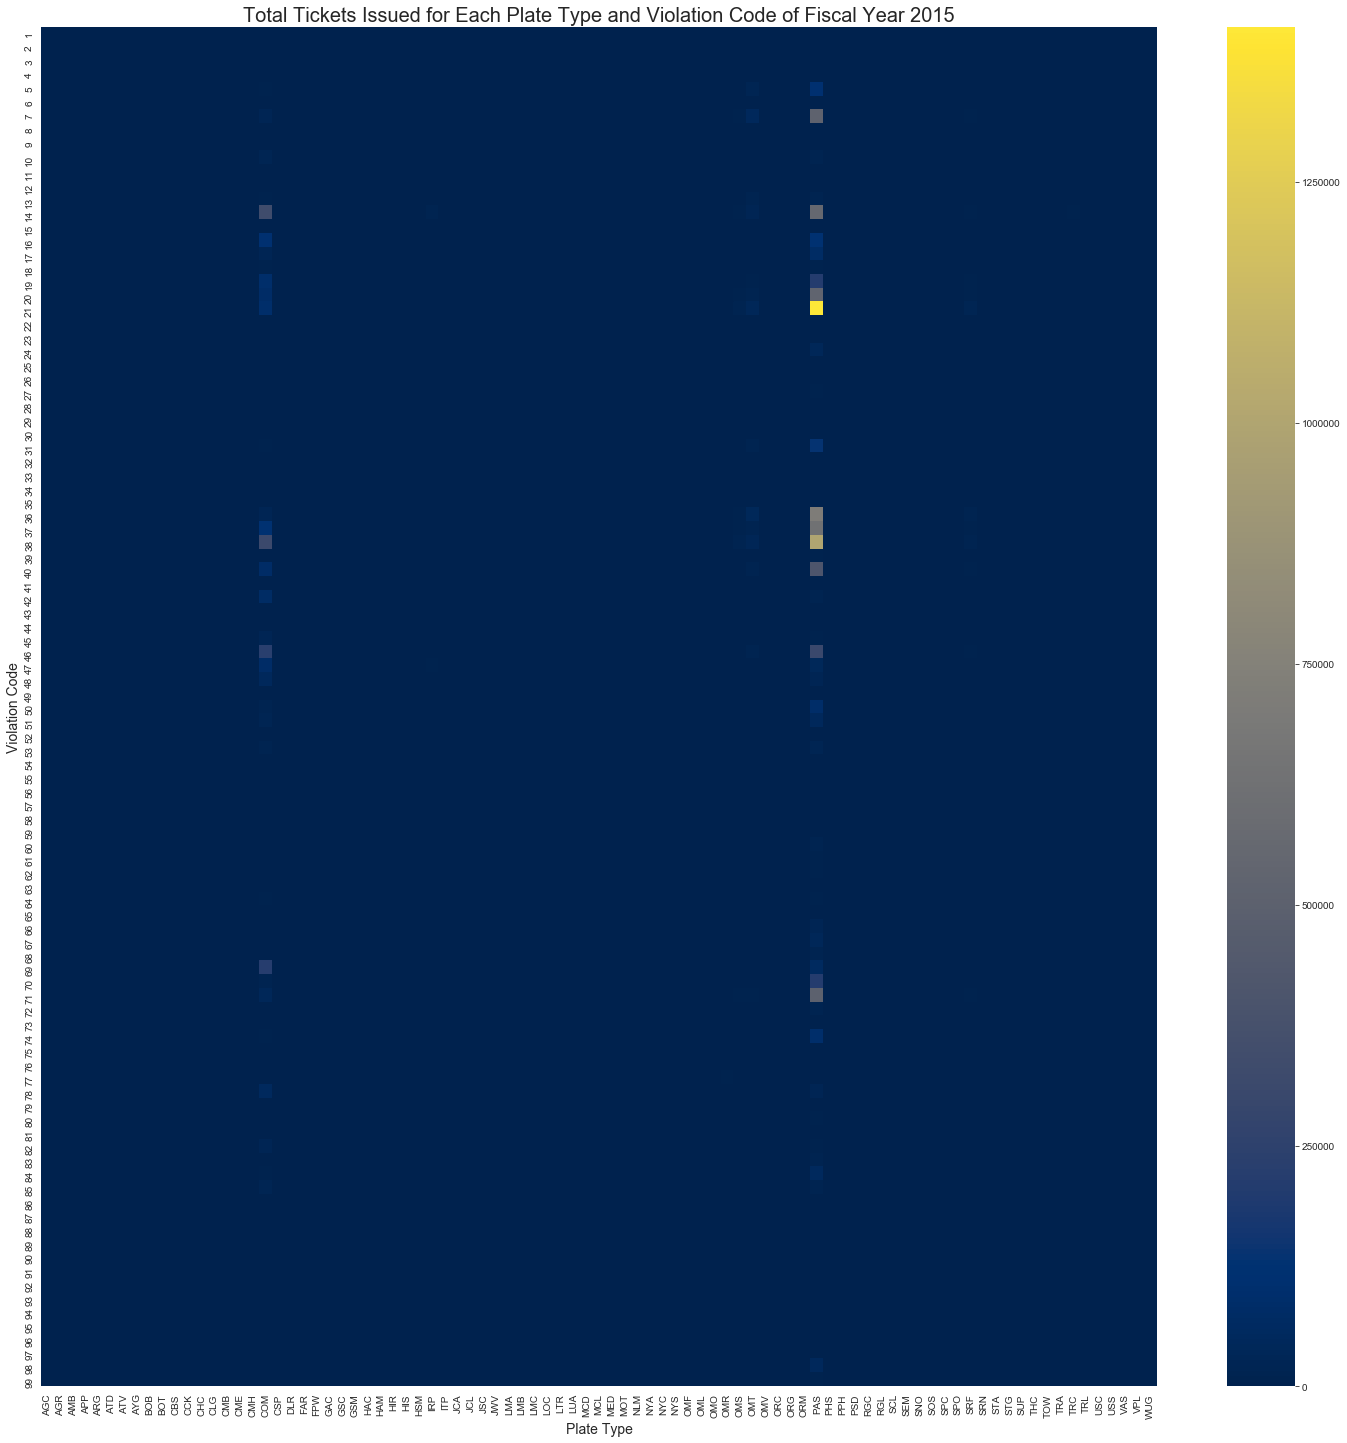

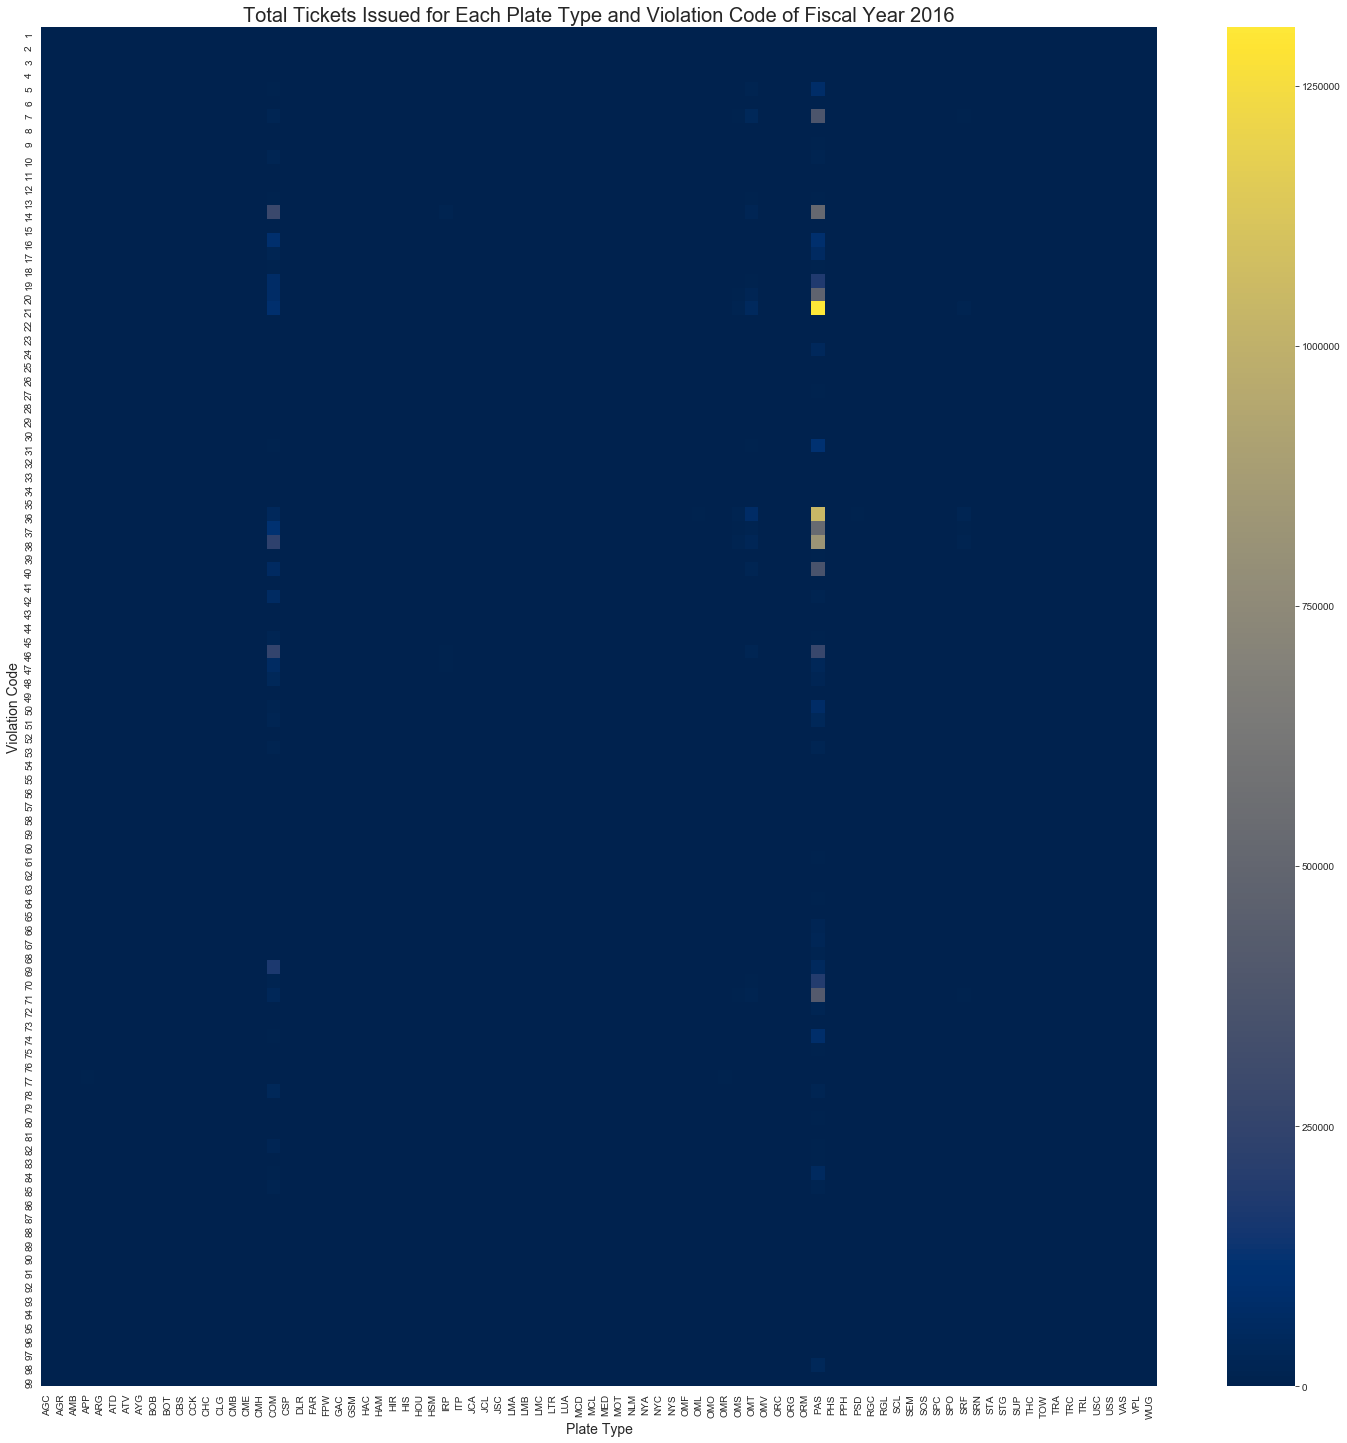

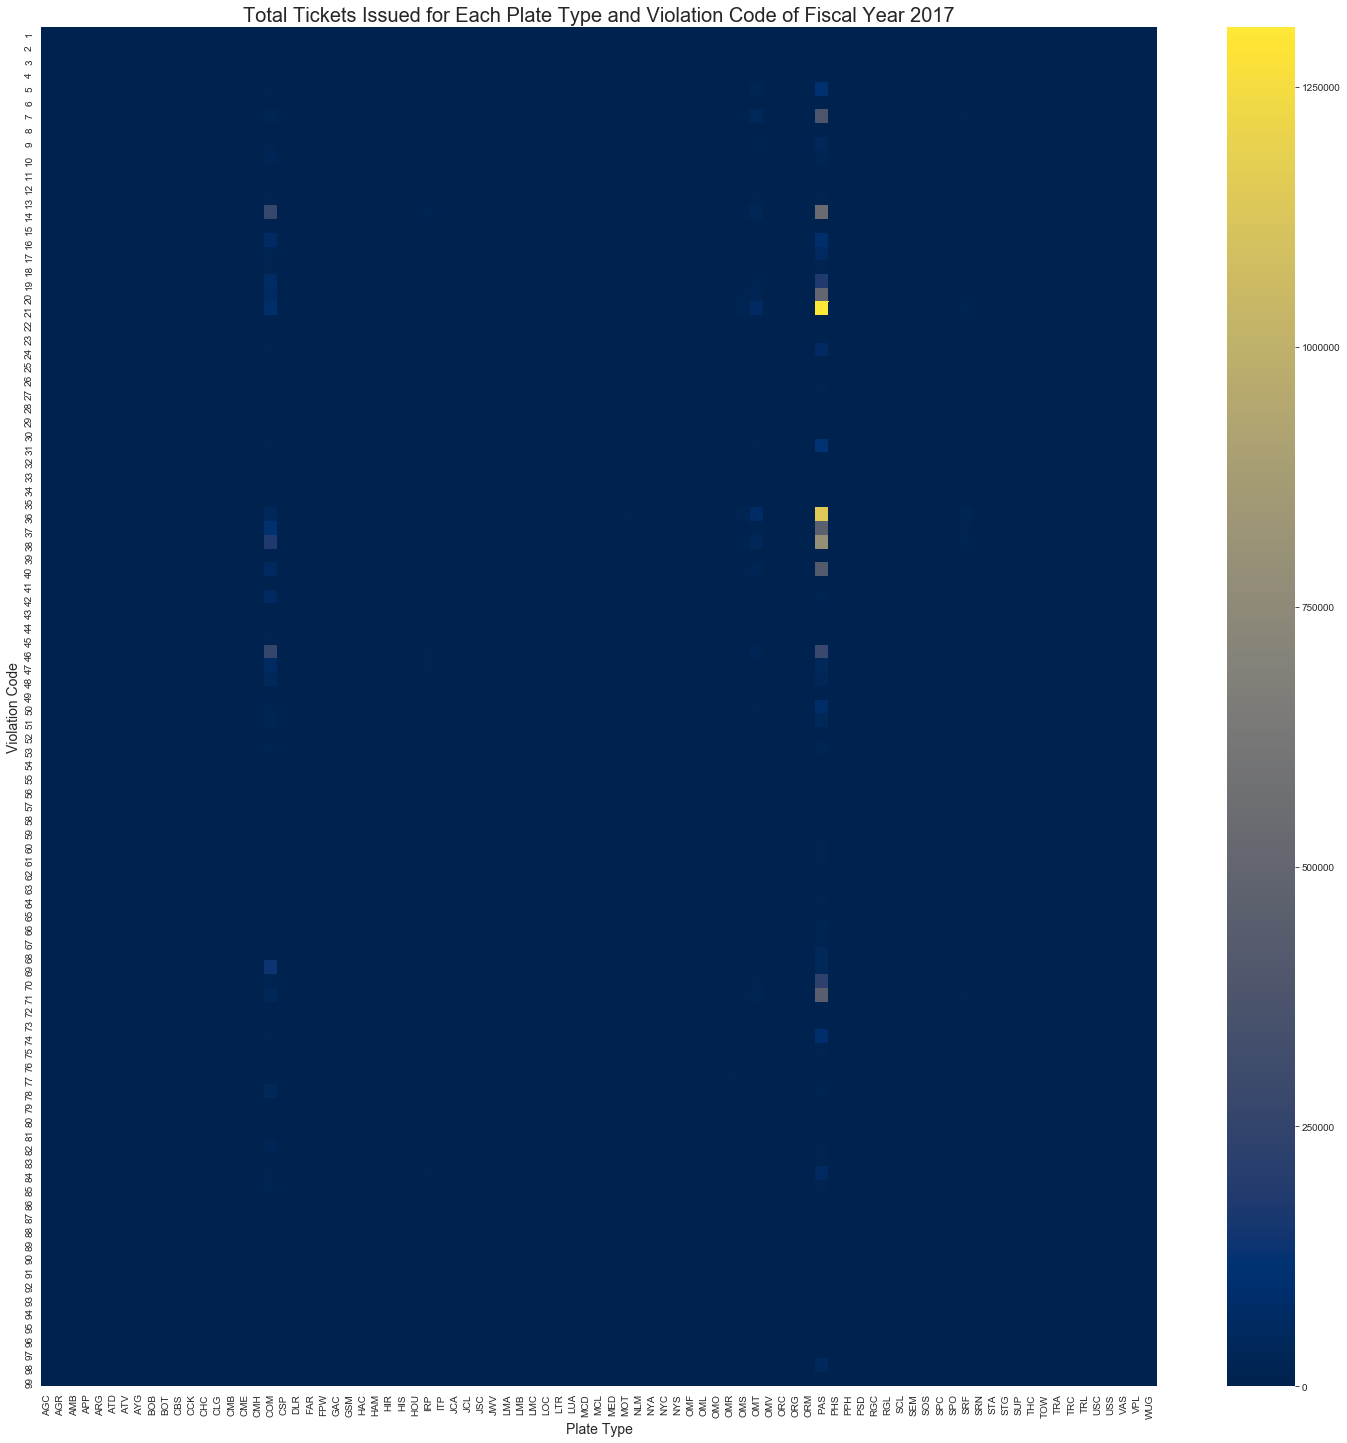

In [536]:
VCode_PT_TotalTX_list = []
for raw_data, start_date, end_date, year in zip(raw_data_15_17, start_dates, end_dates, years): 
    #Create a sub-data set
    Date_VCode_PT_TotalTX = raw_data[['Issue Date','Violation Code','Plate Type','Summons Number']]
    Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.fillna("not_valid") 
    Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.groupby(['Issue Date','Plate Type','Violation Code'], as_index = False).count()
    Date_VCode_PT_TotalTX['Issue Date'] = pd.to_datetime(Date_VCode_PT_TotalTX['Issue Date'])
    Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.set_index('Issue Date')
    Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.loc[start_date:end_date]
    Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.loc[Date_VCode_PT_TotalTX['Plate Type'] != '999']
    Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.loc[Date_VCode_PT_TotalTX['Violation Code'] != 0]

    VCode_PT_TotalTX = Date_VCode_PT_TotalTX.groupby(['Violation Code', 'Plate Type']).sum().reset_index()
    VCode_PT_TotalTX = VCode_PT_TotalTX.fillna(0)
    VCode_PT_TotalTX = VCode_PT_TotalTX.rename(columns = {'Summons Number' : 'Total Tickets'})
    VCode_PT_TotalTX_list.append(VCode_PT_TotalTX)

    #All violation codes and plate type heat plot
    fig, ax = plt.subplots(1,1, figsize = (25,25))
    VCode_PT_TotalTX_all = VCode_PT_TotalTX.pivot(index='Violation Code', columns='Plate Type', values='Total Tickets')
    VCode_PT_TotalTX_all = VCode_PT_TotalTX_all.fillna(0)
    sns.heatmap(ax = ax, data = VCode_PT_TotalTX_all, cmap = "cividis")
    ax.set_title("Total Tickets Issued for Each Plate Type and Violation Code of Fiscal Year " + str(year) ,fontsize = 20)
    ax.set_xlabel("Plate Type", fontsize = 14)
    ax.set_ylabel("Violation Code", fontsize = 14)

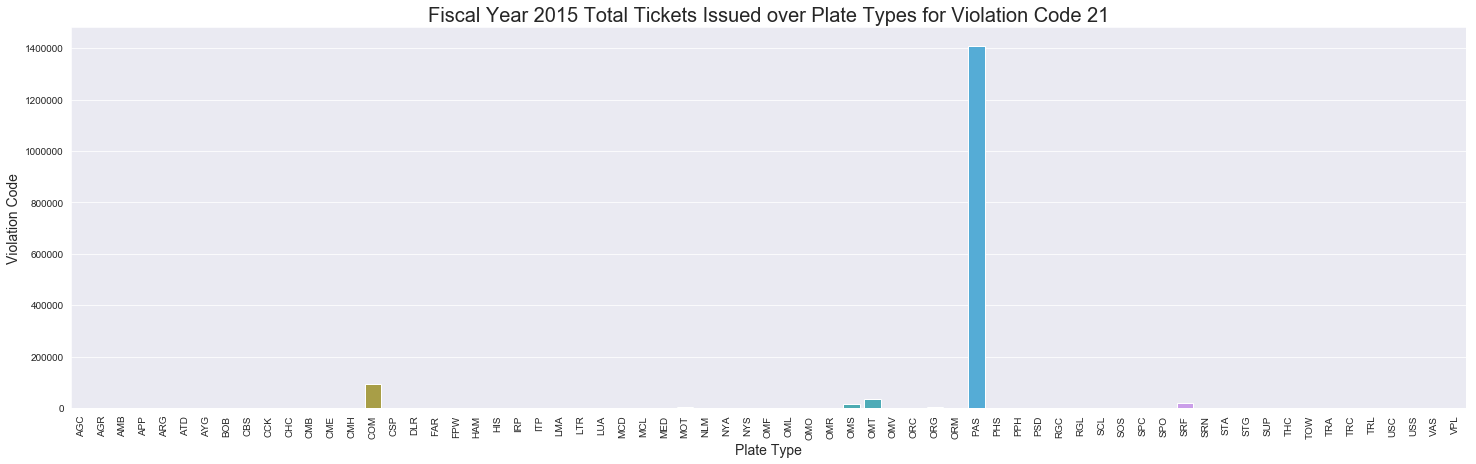

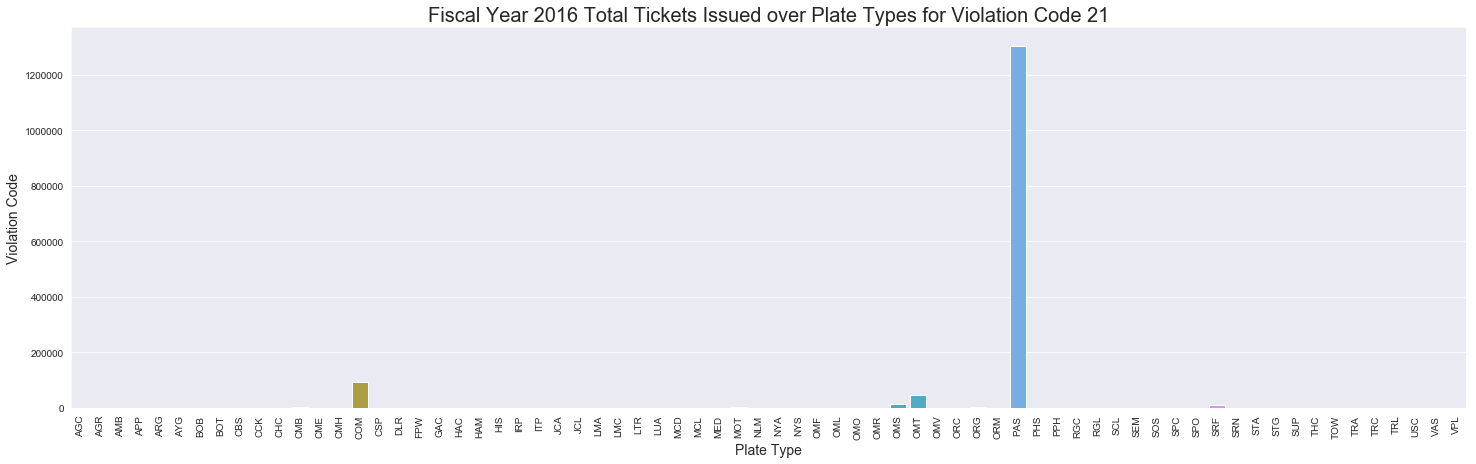

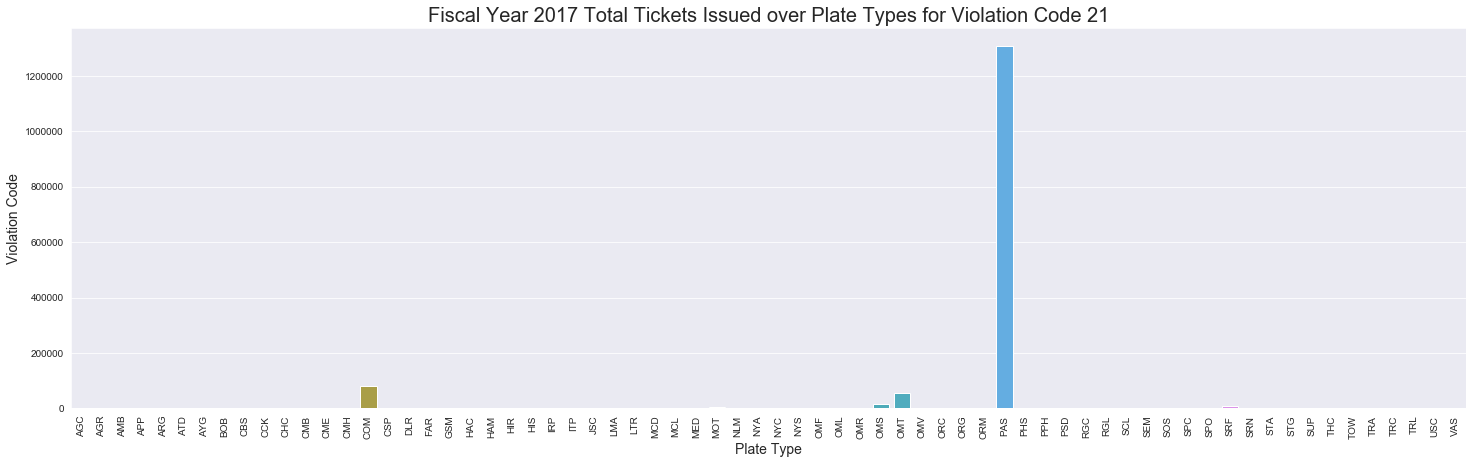

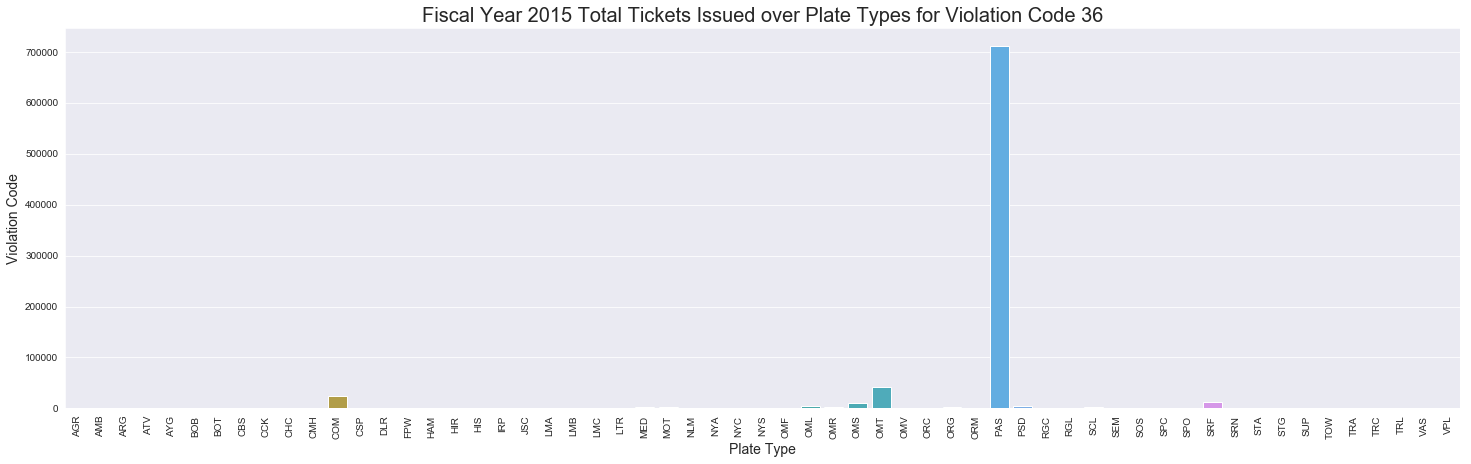

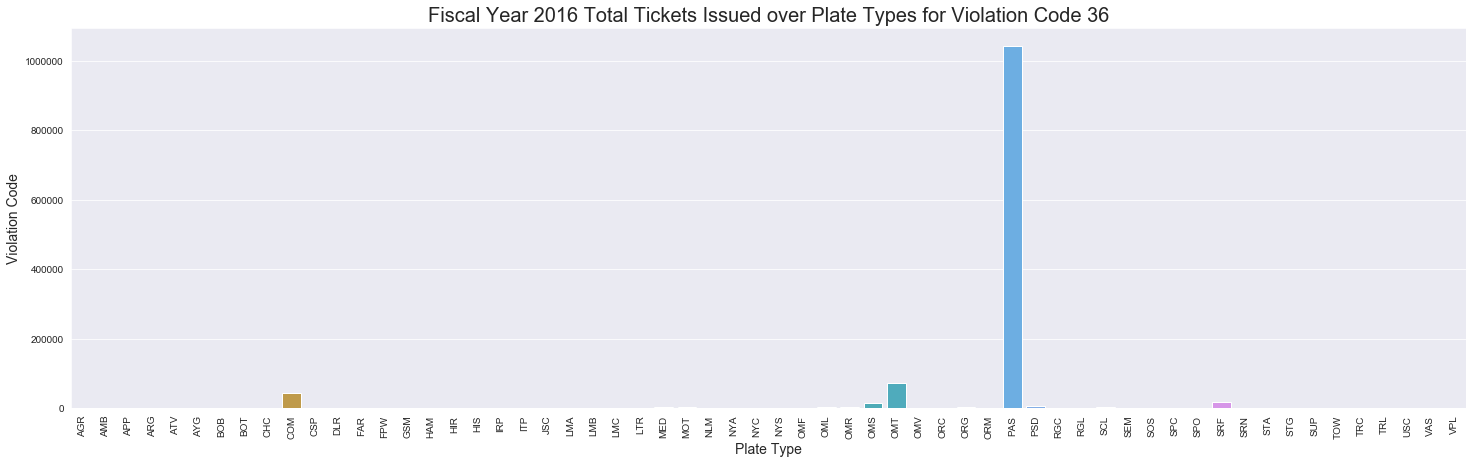

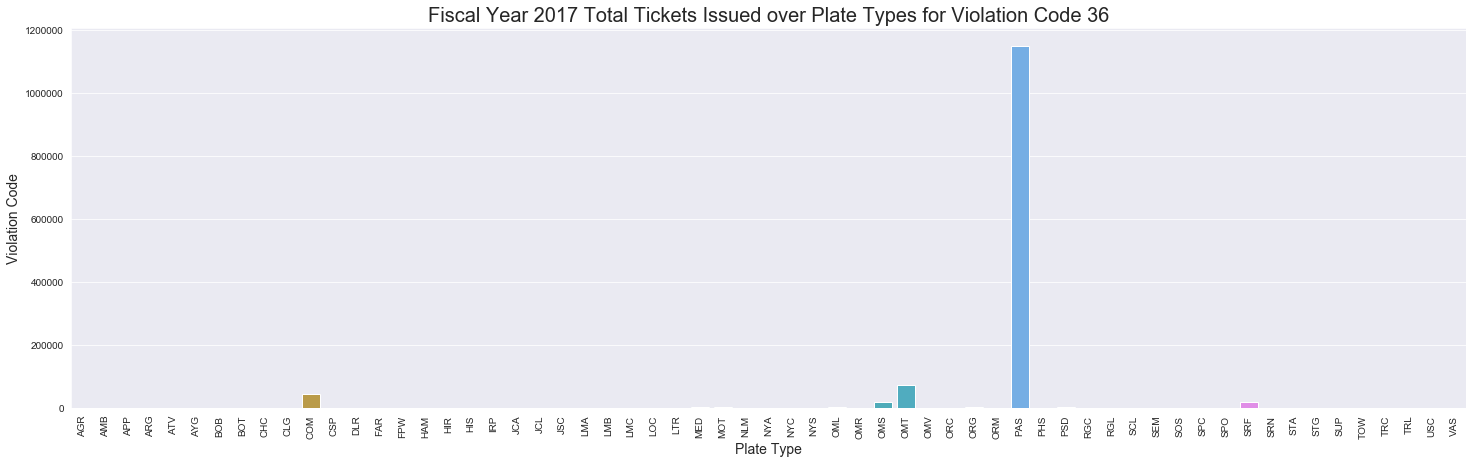

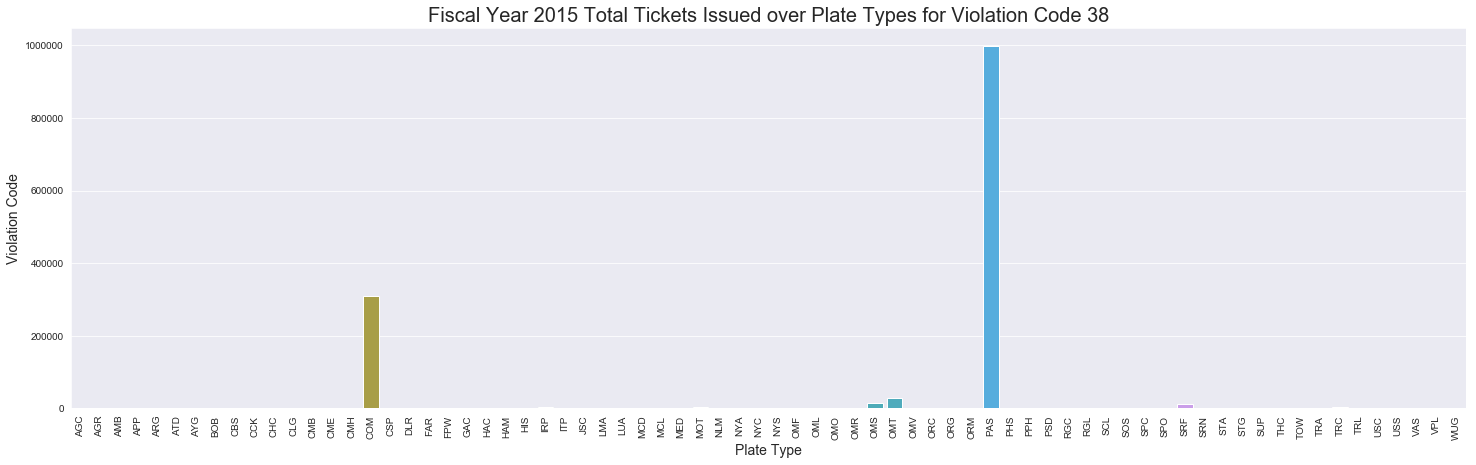

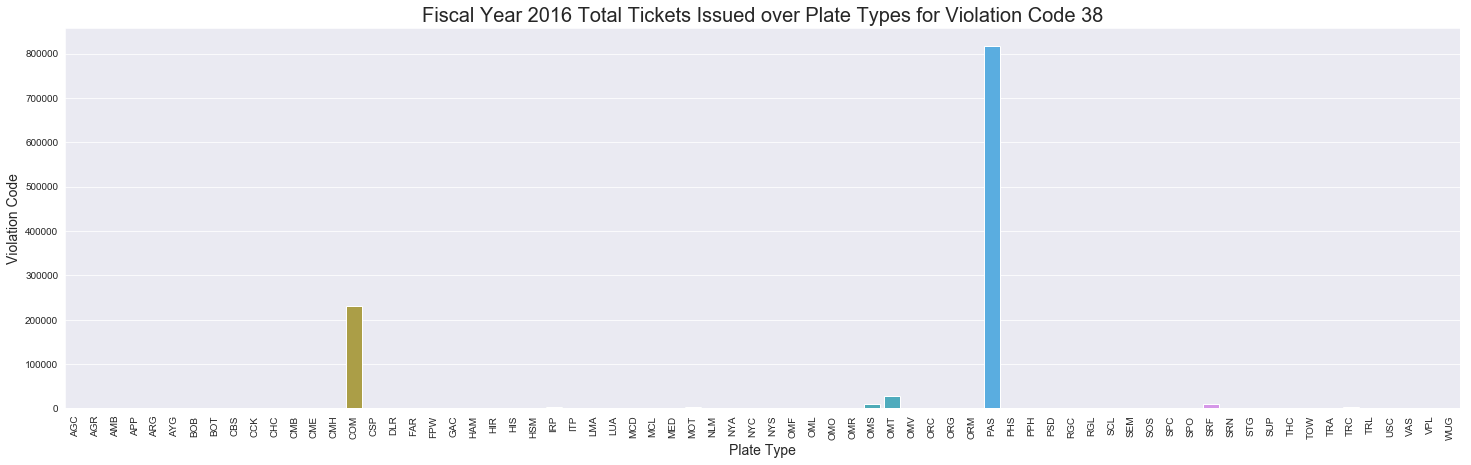

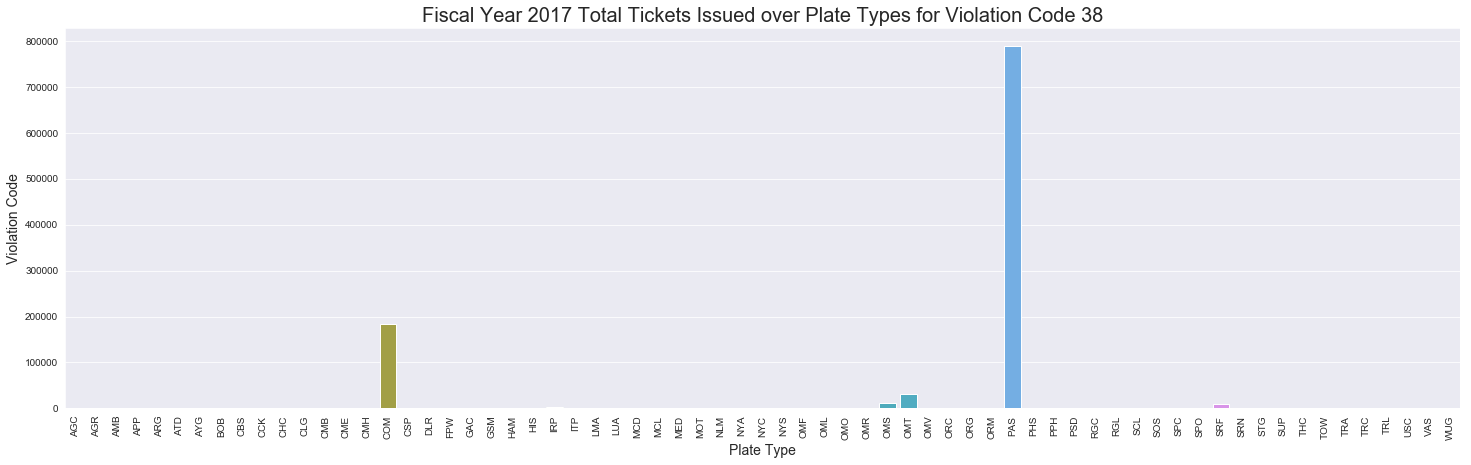

In [537]:
for i in [21,36,38]:
    for VCode_PT_TotalTX, year in zip(VCode_PT_TotalTX_list,years):
    #individual violation code
        selected_df = VCode_PT_TotalTX.loc[VCode_PT_TotalTX['Violation Code'] == i]
        fig8, ax8 = plt.subplots(1,1, figsize = (25,7))
        sns.set_style("darkgrid")
        sns.barplot(x = 'Plate Type', y = 'Total Tickets', data = selected_df)
        ax8.set_title("Fiscal Year " + str(year) + " Total Tickets Issued over Plate Types for Violation Code " + str(i) ,fontsize = 20)
        ax8.set_xlabel("Plate Type", fontsize = 14)
        ax8.set_ylabel("Violation Code", fontsize = 14)
        ax8 = ax8.set_xticklabels(selected_df['Plate Type'], rotation=90, ha = 'center')

#### 6.  Plate Type = PAS, Violation Code = 21

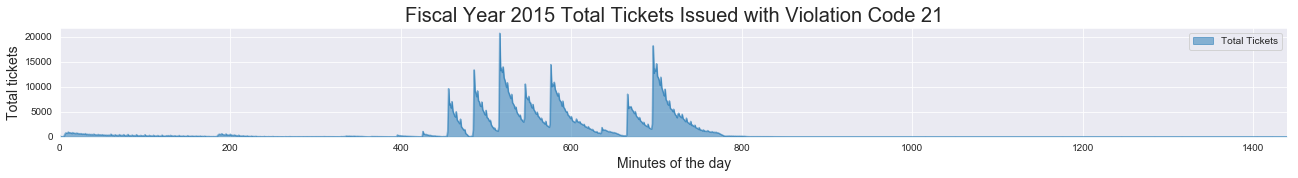

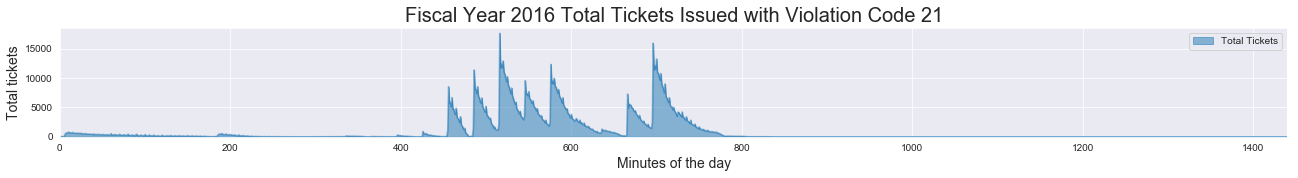

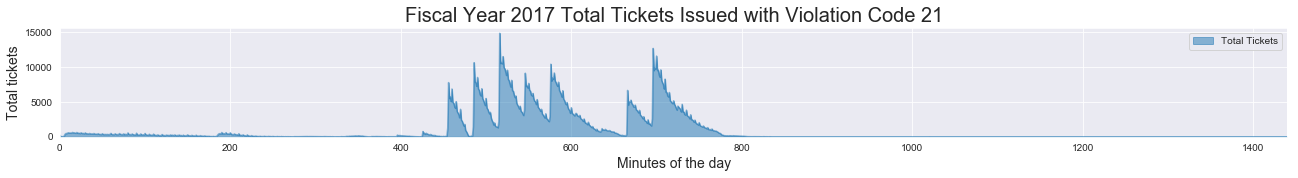

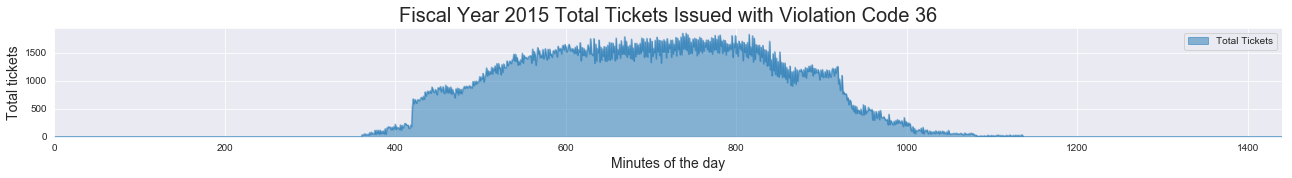

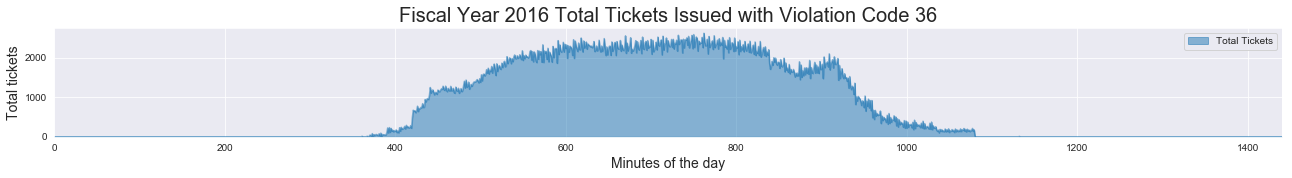

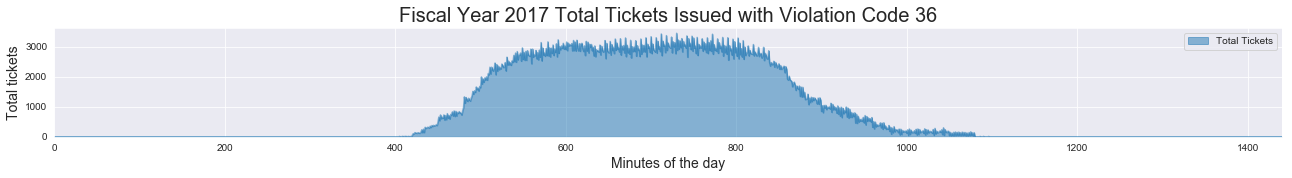

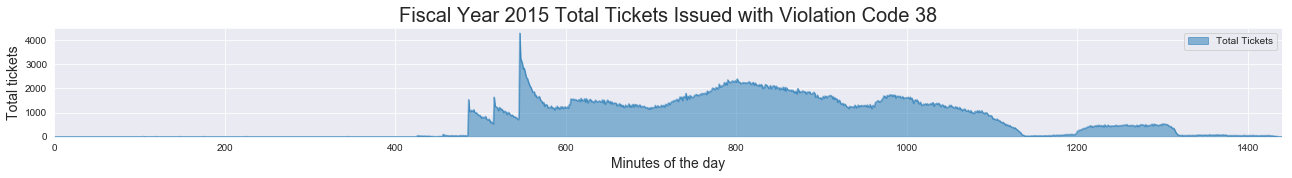

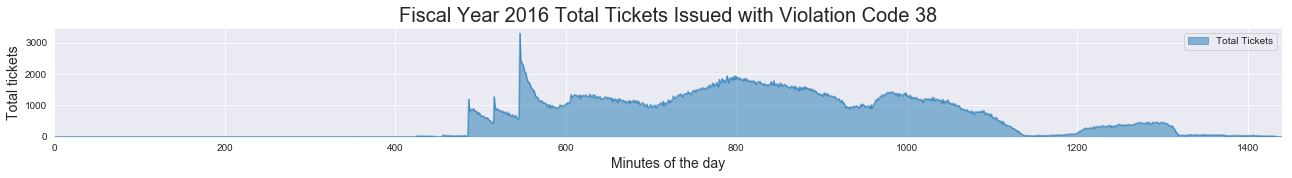

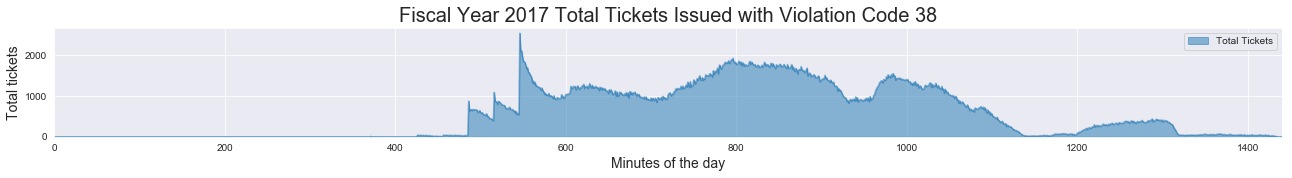

In [532]:
for i in [21,36,38]:
    for raw_data, year in zip(raw_data_15_17,years):
        PAS_hour_data = raw_data[['Violation Time', 'Summons Number', 'Violation Code', 'Plate Type']]
        PAS_hour_data = PAS_hour_data.loc[PAS_hour_data['Plate Type'] == 'PAS']
        PAS_hour_data = PAS_hour_data.loc[PAS_hour_data['Violation Code'] == i]
        PAS_hour_data = PAS_hour_data.groupby('Violation Time', as_index = False).count()
        PAS_hour_data = PAS_hour_data.loc[PAS_hour_data['Summons Number'] > 10] #I found this is a very effective way to filter all invalid data entries since they are all infrequent events.
        PAS_hour_data = PAS_hour_data.rename(columns = {'Summons Number' : 'Total Tickets'})
        PAS_hour_data['Cleaned Violation Time'] = PAS_hour_data['Violation Time'].apply(cleanViolationTime)
        PAS_hour_data = PAS_hour_data.groupby('Cleaned Violation Time').sum()
        PAS_hour_data=PAS_hour_data[['Total Tickets']]
        idx = range(1441)
        PAS_hour_data = PAS_hour_data.reindex(idx, fill_value=0)
        fig9 = PAS_hour_data.plot(figsize = (22,2), grid = True, kind = 'area', alpha = 0.5)
        plt.title("Fiscal Year " + str(year) + " Total Tickets Issued with Violation Code " + str(i) ,fontsize = 20)
        fig9.set_xlabel("Minutes of the day", fontsize = 14)
        fig9.set_ylabel("Total tickets", fontsize = 14)
        sns.set_style('darkgrid')


#### 7. Total Tickets Issued by Each Precinct of NYC 

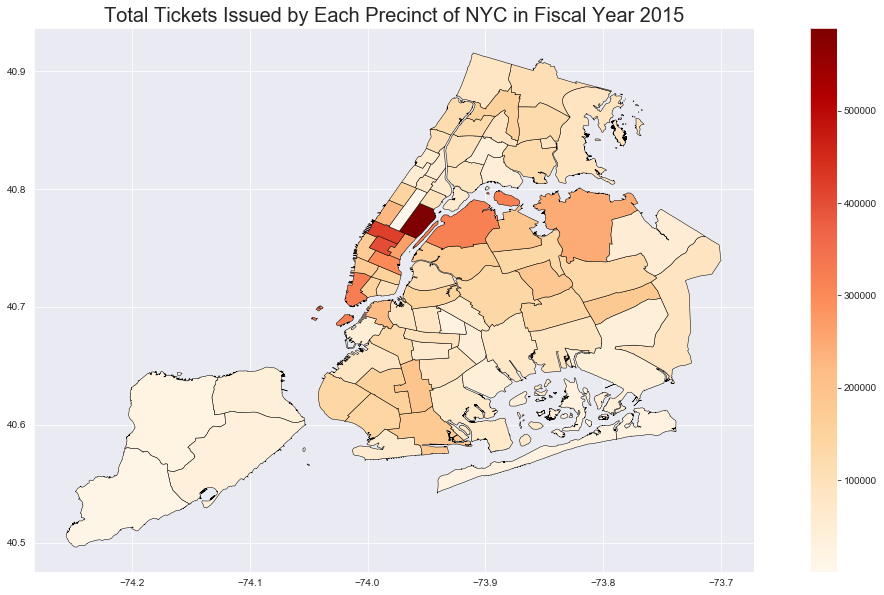

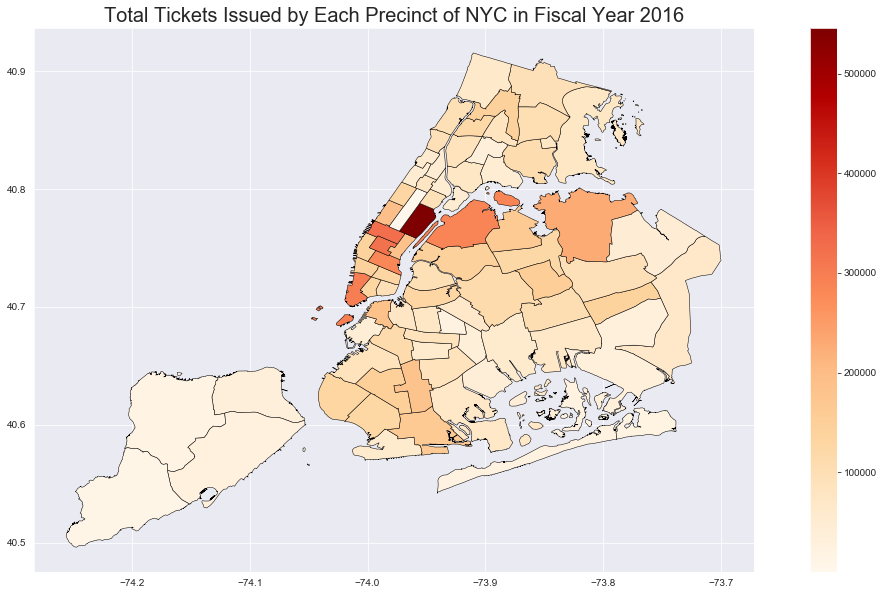

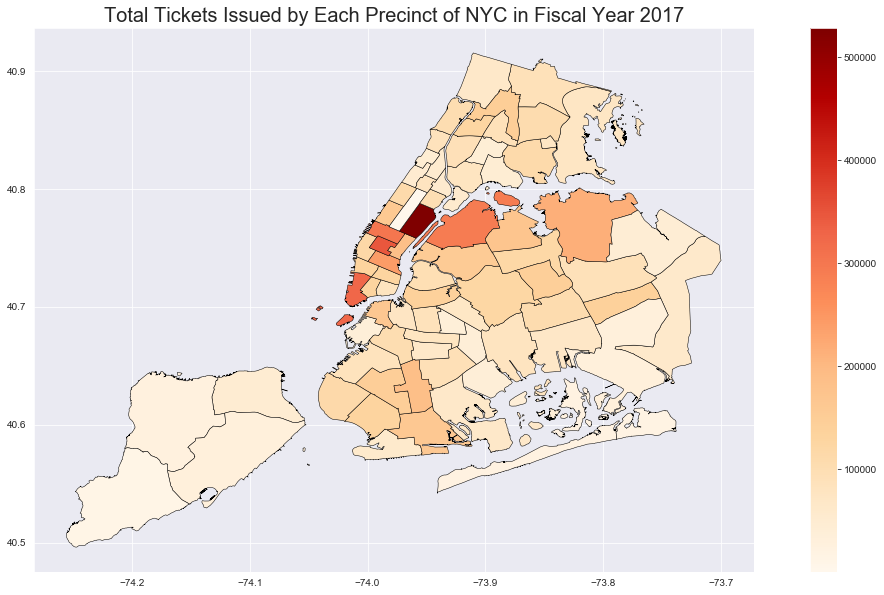

In [528]:
for raw_data, start_date, end_date, year in zip(raw_data_15_17, start_dates, end_dates, years):   
    Date_Precinct_TotalTX = raw_data[['Issue Date','Violation Precinct','Summons Number']]
    #Group data based on issue date and precinct
    Date_Precinct_TotalTX = Date_Precinct_TotalTX.groupby(['Issue Date','Violation Precinct'], as_index = False).count()
    Date_Precinct_TotalTX['Issue Date'] = pd.to_datetime(Date_Precinct_TotalTX['Issue Date'])
    Date_Precinct_TotalTX = Date_Precinct_TotalTX.set_index('Issue Date')
    #locate data within the approporiate fiscal year range
    Date_Precinct_TotalTX = Date_Precinct_TotalTX[start_date:end_date]
    #Group data base on precinct
    Precinct_TotalTX = Date_Precinct_TotalTX.groupby('Violation Precinct').sum()
    #remove invalid precinct entries
    Precinct_TotalTX = Precinct_TotalTX[1:124]
    Precinct_TotalTX = Precinct_TotalTX.drop([2,3,4,8,11,12,15,16,21,27,29,31,35,36,37,38,39,51,53,54,55,56,57,58,59,64,65,74,80,82,85,86,87,89,91,92,93,95,96,97,98,99,116,117,118,119])

    #Precinct Heat Map
    map_path = "./precinct_map/geo_export_1ac7dc26-ca74-4ae0-8bef-28d6099c5e96.shp"
    data = gpd.read_file(map_path)
    data = data.set_index('precinct')
    data = pd.concat([data,Precinct_TotalTX], axis = 1)
    fig, ax = plt.subplots(1, 1, figsize = (20,10))
    data.plot(column='Summons Number', legend=True, ax = ax, cmap = 'OrRd',linewidth = 0.5, edgecolor = 'k')
    ax.set_title("Total Tickets Issued by Each Precinct of NYC in Fiscal Year " + str(year), Fontsize = 20)
    
    